# You need 256Gb for this script!

# Methods

And a more complete version accounting for all processes, according to Seager 2010:

$$ \delta P \approx \delta E - \frac{1}{g} \delta \int ( \mathbf{u} \nabla q + q \nabla \mathbf{u}  ) $$

$$ \delta P \approx \delta E - \frac{1}{g} \int ( \delta \mathbf{u} \nabla q ) + \int ( q \nabla \delta \mathbf{u}  ) $$

thermodynamic:

$$ TH = - \frac{1}{g} \int \nabla \cdot (\mathbf{u} \ \delta q) dp  $$

dynamic:

$$ DYN = - \frac{1}{g} \int \nabla \cdot ( \delta \mathbf{u} \ q) dp  $$




This calculation is based on monthly means. One can also include contributions from eddies (based on daily deviations $\mathbf{u'}$ and  $q'$ from monthly means ):

$$ EDDY = - \frac{1}{g} \int \nabla \cdot ( \delta ( \overline{ \mathbf{u'} \ q'})) dp  $$


we can also decompose the dynamic component into a advective component and convergence component

$$ DYN = - \frac{1}{g} \int \nabla \cdot ( \delta \mathbf{u} \ q) dp =  - \frac{1}{g} \int \delta \mathbf{u} \cdot \nabla q \ dp - \frac{1}{g} \int  q \ \nabla \cdot \delta \mathbf{u} \ dp$$


( in the calculation below we omit the minus bfore the terms, but swap the boundaries of the integral so the sign is correct)

# Define packages, functions

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import metcalc
import pandas as pd
import cartopy.crs as ccrs
import matplotlib.patches as mpatches
import xesmf as xe

print(xr.__version__)

2022.3.0


In [3]:
def read_mm_files(filenames,index=74) :
    def preproc(ds):
        filename = ds.encoding['source']
        month=filename[index]
        if 'plev' in ds.coords :
            ds.coords['plev2'] = ds.plev / 100
            ds = ds.swap_dims({'plev': 'plev2'})
            ds.plev2['units'] = 'hPa'
        ds['month'] = int(month)
        return ds

    return xr.open_mfdataset(filenames,concat_dim="month", combine='nested',preprocess=preproc)

In [4]:
def fix_time(ds):
    # we need be carefull witht he attributes in the time data array, because of a weird xarray bug: https://github.com/pydata/xarray/issues/3739
    t = ds.time
    time1 = pd.to_datetime(t.values, format='%Y%m%d')
    hours = np.round((t.values % 1) * 24,2)
    minutes = (hours % 1) * 60
    time2 = pd.to_datetime(hours, format='%H')
    time3 = pd.to_datetime(minutes, format='%M')
    return xr.DataArray(
        pd.to_datetime(pd.to_numeric(time3-time3[0]) + pd.to_numeric(time2-time2[0]) + pd.to_numeric(time1)),
        dims=t.dims,
        attrs={k:v for k,v in t.attrs.items() if k != "units" and k != "calendar"})

In [5]:
def xr_vertical_integral(ds):
    integrand = ds.sortby("plev", ascending=False).fillna(0)
    return integrand.integrate("plev")


# read Data

In [ ]:
WORK_DIR = "/work/mh0066/m300577/perpetual_jan"

In [9]:
dap0013 = read_mm_files(f"{WORK_DIR}/dap0013-dc/dap0013-dc_hus_20N-20S_19790[2-9]_timemean.nc",index=74)
dap0014 = read_mm_files(f"{WORK_DIR}/dap0014-dc/dap0014-dc_hus_20N-20S_19790[2-9]_timemean.nc",index=74)


In [10]:
dap0013["ua"] = read_mm_files(f"{WORK_DIR}/dap0013-dc/dap0013-dc_ua_20N-20S_19790[2-9]_timemean.nc",index=73).ua
dap0014["ua"] = read_mm_files(f"{WORK_DIR}/dap0014-dc/dap0014-dc_ua_20N-20S_19790[2-9]_timemean.nc",index=73).ua
dap0013["va"] = read_mm_files(f"{WORK_DIR}/dap0013-dc/dap0013-dc_va_20N-20S_19790[2-9]_timemean.nc",index=73).va
dap0014["va"] = read_mm_files(f"{WORK_DIR}/dap0014-dc/dap0014-dc_va_20N-20S_19790[2-9]_timemean.nc",index=73).va


In [11]:
dap0013["prw"] = read_mm_files(f"{WORK_DIR}/dap0013-dc/dap0013-dc_prw_20N-20S_19790[2-9]_timemean.nc",index=74).prw
dap0014["prw"] = read_mm_files(f"{WORK_DIR}/dap0014-dc/dap0014-dc_prw_20N-20S_19790[2-9]_timemean.nc",index=74).prw

In [12]:
dap0013_dm = xr.open_mfdataset(f"{WORK_DIR}/dap0013-dc/dap0013-dc_atm_2d_ml_19790[2-9]??T000000Z_evspsbl_01x01.nc")
dap0014_dm = xr.open_mfdataset(f"{WORK_DIR}/dap0014-dc/dap0014-dc_atm_2d_ml_19790[2-9]??T000000Z_evspsbl_01x01.nc")

dap0013_dm["pr"] = xr.open_mfdataset(f"{WORK_DIR}/dap0013-dc/dap0013-dc_atm_2d_ml_19790[2-9]??T000000Z_pr_01x01.nc").pr
dap0014_dm["pr"] = xr.open_mfdataset(f"{WORK_DIR}/dap0014-dc/dap0014-dc_atm_2d_ml_19790[2-9]??T000000Z_pr_01x01.nc").pr

levels = np.array([1000,850,700,500,400,300,250,200,150]) * 100.


In [13]:
dap0013_dm = dap0013_dm.assign_coords(time=fix_time(dap0013_dm))
dap0014_dm = dap0014_dm.assign_coords(time=fix_time(dap0014_dm))

In [14]:
dap0013_dm_mm = dap0013_dm.resample(time="M").mean()
dap0014_dm_mm = dap0014_dm.resample(time="M").mean()

In [15]:
dap0013["evap"]=dap0013_dm_mm.assign_coords(month = ("time", dap0013.month.values) ).swap_dims({'time': 'month'}).evspsbl
dap0014["evap"]=dap0014_dm_mm.assign_coords(month = ("time", dap0014.month.values) ).swap_dims({'time': 'month'}).evspsbl
dap0013["pr"]=dap0013_dm_mm.assign_coords(month = ("time", dap0013.month.values) ).swap_dims({'time': 'month'}).pr
dap0014["pr"]=dap0014_dm_mm.assign_coords(month = ("time", dap0014.month.values) ).swap_dims({'time': 'month'}).pr



Evaporation and precipitaion are in $\frac{kg}{m^2 s}$, specific humidity is kg/kg

# Do calculations

In [17]:
g = 9.81


In [18]:
recalc_DYN_THERMO = False
recalc_EDDY = False

In [19]:
dap_diff = dap0014.mean("month") - dap0013.mean("month")
dap_mean = dap0013.mean("month")
dap_diff = dap_diff.compute()
dap_mean = dap_mean.compute()


In [20]:
P_minus_E = (dap_diff.pr + dap_diff.evap)

delta_P =  dap_diff.pr
delta_E =  dap_diff.evap

In [21]:

del dap0013_dm
del dap0014_dm


## Dynamic and thermodynamic components

In [22]:
if recalc_DYN_THERMO :

    ua_times_delta_q = dap_mean.ua * dap_diff.hus
    q_times_delta_ua = dap_mean.hus * dap_diff.ua

    va_times_delta_q = dap_mean.va * dap_diff.hus
    q_times_delta_va = dap_mean.hus * dap_diff.va

    # non linear
    delta_va_times_delta_q = dap_diff.va * dap_diff.hus
    delta_ua_times_delta_q = dap_diff.ua * dap_diff.hus

    thermo_before_integral =metcalc.x_derivative(ua_times_delta_q) + metcalc.y_derivative(va_times_delta_q)
    dynamic_before_integral =metcalc.x_derivative(q_times_delta_ua) + metcalc.y_derivative(q_times_delta_va)
    nonlinear_before_integral =metcalc.x_derivative(delta_ua_times_delta_q) + metcalc.y_derivative(delta_va_times_delta_q)

    dynamic_advection_before_integral = dap_diff.ua *metcalc.x_derivative(dap_mean.hus) + dap_diff.va * metcalc.y_derivative(dap_mean.hus)
    dynamic_convergence_before_integral = dap_mean.hus *metcalc.x_derivative(dap_diff.ua) + dap_mean.hus * metcalc.y_derivative(dap_diff.va)

    thermo = xr_vertical_integral(thermo_before_integral)/g
    dynamic = xr_vertical_integral(dynamic_before_integral)/g
    nonlinear = xr_vertical_integral(nonlinear_before_integral)/g

    dynamic_advection = xr_vertical_integral(dynamic_advection_before_integral)/g
    dynamic_convergence = xr_vertical_integral(dynamic_convergence_before_integral)/g
    
    thermo.to_dataset(name="pr").to_netcdf(f"{WORK_DIR}/thermo_pr_term.nc")
    dynamic.to_dataset(name="pr").to_netcdf(f"{WORK_DIR}/dynamic_pr_term.nc")
    nonlinear.to_dataset(name="pr").to_netcdf(f"{WORK_DIR}/nonlinear_pr_term.nc")
    dynamic_advection.to_dataset(name="pr").to_netcdf(f"{WORK_DIR}/dynamic_advection_pr_term.nc")
    dynamic_convergence.to_dataset(name="pr").to_netcdf(f"{WORK_DIR}/dynamic_convergence_pr_term.nc")


## Eddy component

To make things easy on the memory, we calculate this month by month

In [23]:
if recalc_EDDY :
    months = list(np.arange(2,10))

    dap0013_ua_prime_times_q_prime = []
    dap0014_ua_prime_times_q_prime = []
    dap0013_va_prime_times_q_prime = []
    dap0014_va_prime_times_q_prime = []

    for mon in months :
        print(mon)

        dap0013_dm = xr.open_mfdataset(f"{WORK_DIR}/dap0013-dc/dap0013-dc_hus_20N-20S_19790{mon}.nc",parallel=True,chunks={"plev" : 1}).sel(plev=levels)
        dap0014_dm = xr.open_mfdataset(f"{WORK_DIR}/dap0014-dc/dap0014-dc_hus_20N-20S_19790{mon}.nc",parallel=True,chunks={"plev" : 1}).sel(plev=levels)

        dap0013_dm["ua"] = xr.open_mfdataset(f"{WORK_DIR}/dap0013-dc/dap0013-dc_ua_20N-20S_19790{mon}.nc",parallel=True,chunks={"plev" : 1}).ua.sel(plev=levels)
        dap0014_dm["ua"] = xr.open_mfdataset(f"{WORK_DIR}/dap0014-dc/dap0014-dc_ua_20N-20S_19790{mon}.nc",parallel=True,chunks={"plev" : 1}).ua.sel(plev=levels)

        dap0013_dm["va"] = xr.open_mfdataset(f"{WORK_DIR}/dap0013-dc/dap0013-dc_va_20N-20S_19790{mon}.nc",parallel=True,chunks={"plev" : 1}).va.sel(plev=levels)
        dap0014_dm["va"] = xr.open_mfdataset(f"{WORK_DIR}/dap0014-dc/dap0014-dc_va_20N-20S_19790{mon}.nc",parallel=True,chunks={"plev" : 1}).va.sel(plev=levels)

        dap0013_dm_dev = dap0013_dm - dap0013_dm.mean("time")
        dap0014_dm_dev = dap0014_dm - dap0014_dm.mean("time")

        dap0013_ua_prime_times_q_prime_ = dap0013_dm_dev.hus * dap0013_dm_dev.ua
        dap0013_va_prime_times_q_prime_ = dap0013_dm_dev.hus * dap0013_dm_dev.va

        dap0013_ua_prime_times_q_prime.append(dap0013_ua_prime_times_q_prime_.mean("time").compute())
        dap0013_va_prime_times_q_prime.append(dap0013_va_prime_times_q_prime_.mean("time").compute())

        dap0014_ua_prime_times_q_prime_ = dap0014_dm_dev.hus * dap0014_dm_dev.ua
        dap0014_va_prime_times_q_prime_ = dap0014_dm_dev.hus * dap0014_dm_dev.va

        dap0014_ua_prime_times_q_prime.append(dap0014_ua_prime_times_q_prime_.mean("time").compute())
        dap0014_va_prime_times_q_prime.append(dap0014_va_prime_times_q_prime_.mean("time").compute())

    
    dap0013_ua_prime_times_q_prime_xr = xr.concat(dap0013_ua_prime_times_q_prime,xr.DataArray(months, {"month" : months}))
    dap0013_va_prime_times_q_prime_xr = xr.concat(dap0013_va_prime_times_q_prime,xr.DataArray(months, {"month" : months}))
    dap0014_ua_prime_times_q_prime_xr = xr.concat(dap0014_ua_prime_times_q_prime,xr.DataArray(months, {"month" : months}))
    dap0014_va_prime_times_q_prime_xr = xr.concat(dap0014_va_prime_times_q_prime,xr.DataArray(months, {"month" : months}))


    dap_diff_ua_prime_times_q_prime = dap0014_ua_prime_times_q_prime_xr.mean("month") - dap0013_ua_prime_times_q_prime_xr.mean("month")
    dap_diff_va_prime_times_q_prime = dap0014_va_prime_times_q_prime_xr.mean("month") - dap0013_va_prime_times_q_prime_xr.mean("month")

    eddy_before_integral =metcalc.x_derivative(dap_diff_ua_prime_times_q_prime) + metcalc.y_derivative(dap_diff_va_prime_times_q_prime)

    eddy_term = xr_vertical_integral(eddy_before_integral)/g
    eddy_term.to_dataset(name="pr").to_netcdf(f"{WORK_DIR}/eddy_pr_term.nc")

# Open calculated Data

In [24]:
#reopen

thermo= xr.open_dataset(f"{WORK_DIR}/thermo_pr_term.nc").pr
dynamic= xr.open_dataset(f"{WORK_DIR}/dynamic_pr_term.nc").pr
dynamic_convergence= xr.open_dataset(f"{WORK_DIR}/dynamic_convergence_pr_term.nc").pr
dynamic_advection= xr.open_dataset(f"{WORK_DIR}/dynamic_advection_pr_term.nc").pr
eddy_term= xr.open_dataset(f"{WORK_DIR}/eddy_pr_term.nc").pr
nonlinear= xr.open_dataset(f"{WORK_DIR}/nonlinear_pr_term.nc").pr


Coarsen resolution and convert to g m-2 s-1

In [32]:
thermo_LR = thermo.coarsen(lon=5,lat=5).mean() * 1000.
dynamic_LR = dynamic.coarsen(lon=5,lat=5).mean() * 1000.
nonlinear_LR = nonlinear.coarsen(lon=5,lat=5).mean() * 1000.
eddy_term_LR = eddy_term.coarsen(lon=5,lat=5).mean() * 1000.
delta_P_LR = delta_P.coarsen(lon=5,lat=5).mean() * 1000.
delta_E_LR = delta_E.coarsen(lon=5,lat=5).mean() * 1000.
delta_E_LR_pos = - delta_E.coarsen(lon=5,lat=5).mean() * 1000.

dynamic_advection_LR = dynamic_advection.coarsen(lon=5,lat=5).mean() * 1000.
dynamic_convergence_LR = dynamic_convergence.coarsen(lon=5,lat=5).mean() * 1000.


Precipitation and Evaporation are from the ground perspective, thus precipitation is positive and evaporation is negative. For an atmospheric moisture budget, we need to switch the signs:

In [31]:
sum_terms = thermo + dynamic + eddy_term + nonlinear  - delta_E
sum_terms_LR = thermo_LR + dynamic_LR + eddy_term_LR + nonlinear_LR  - delta_E_LR

residual = thermo + dynamic + eddy_term + nonlinear - delta_E - delta_P
residual_LR = thermo_LR + dynamic_LR + eddy_term_LR + nonlinear_LR - delta_E_LR - delta_P_LR


# evap must balance P, but P is positve and E is negative. To balance, you need to add here!
residual2 = thermo + dynamic - delta_E - delta_P
residual2_LR = delta_P_LR + delta_E_LR - thermo_LR - dynamic_LR 


In [25]:
thermo_zonmean = thermo_LR.mean("lon")
dynamic_zonmean = dynamic_LR.mean("lon")
pr_zonmean = delta_P_LR.mean("lon")
sum_terms_zonmean = sum_terms_LR.mean("lon")


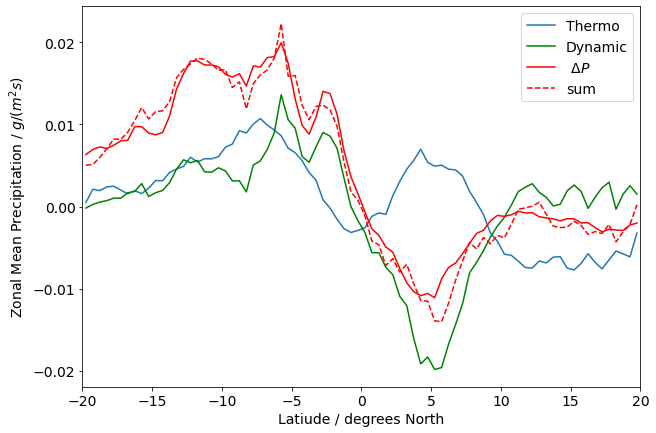

In [26]:
plt.rc('font',size=14)

fig,ax = plt.subplots(1,1,figsize=(10,7))

thermo_zonmean.plot(x="lat",ax=ax,label=f"Thermo")
dynamic_zonmean.plot(x="lat",ax=ax,color="green",label=f"Dynamic")
pr_zonmean.plot(x="lat",ax=ax,color="red",label=f" $ \Delta P $")
sum_terms_zonmean.plot(x="lat",ax=ax,color="red",ls="--",label=f"sum")
ax.set_xlim(-20,20)
ax.set_xlabel(f"Latiude / degrees North")
ax.set_ylabel(f"Zonal Mean Precipitation / $ g/(m^2 s) $")
ax.legend()


# Plotting

In [27]:
#plt.rc('text', usetex=True)
plt.rc('font',size=18)

## All terms

In [28]:
pwd()

'/home/m/m300577/scripts'

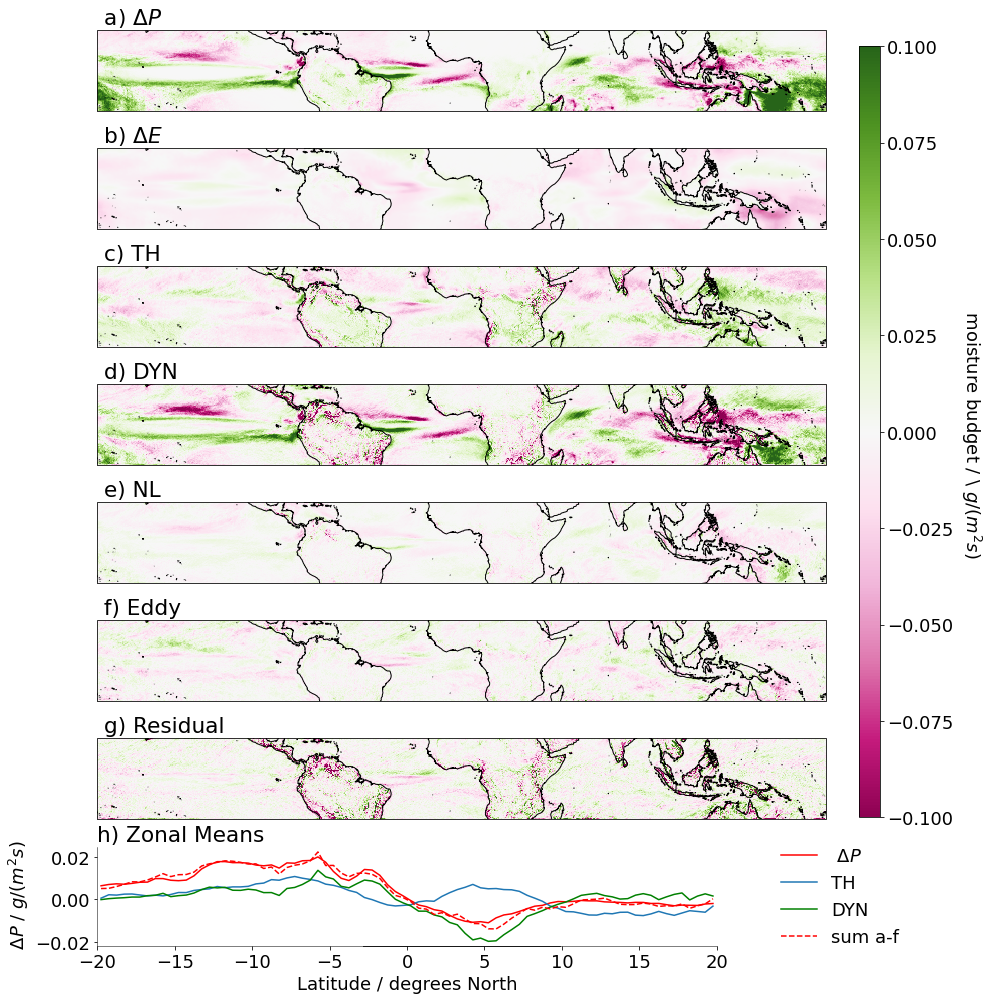

In [29]:
fig,xs = plt.subplots(8,1,figsize=(15,17), subplot_kw={'projection': ccrs.PlateCarree()},facecolor="white")

clim=1e-1

ax=xs[0]
im =  delta_P_LR.plot(x="lon",y="lat",ax=ax,cmap='PiYG',add_colorbar=False,vmin=-clim,vmax=clim)

metcalc.set_regional_cartopy(ax,extent=[0, 359, -20, 20])
ax.set_title(f" a) $ \Delta P $",loc="left")

ax=xs[1]
im =  delta_E_LR.plot(x="lon",y="lat",ax=ax,cmap='PiYG',add_colorbar=False,vmin=-clim,vmax=clim)

metcalc.set_regional_cartopy(ax,extent=[0, 359, -20, 20])
ax.set_title(f" b) $ \Delta E $",loc="left")

ax=xs[2]
im =  thermo_LR.plot(x="lon",y="lat",ax=ax,cmap='PiYG',vmin=-clim,vmax=clim,add_colorbar=False)

metcalc.set_regional_cartopy(ax,extent=[0, 359, -20, 20])
#ax.set_title(fr" $ \int \delta \omega \  \frac{{dq}}{{dp}}$ ")
ax.set_title(f" c) TH ",loc="left")


ax=xs[3]
im =  dynamic_LR.plot(x="lon",y="lat",ax=ax,cmap='PiYG',vmin=-clim,vmax=clim,add_colorbar=False)

metcalc.set_regional_cartopy(ax,extent=[0, 359, -20, 20])
#ax.set_title(fr" $ \int \omega \ \delta \frac{{dq}}{{dp}}$ ")
ax.set_title(f" d) DYN ",loc="left")

ax=xs[4]
im =  nonlinear_LR.plot(x="lon",y="lat",ax=ax,cmap='PiYG',vmin=-clim,vmax=clim,add_colorbar=False)

metcalc.set_regional_cartopy(ax,extent=[0, 359, -20, 20])
#ax.set_title(fr" $ \int \omega \ \delta \frac{{dq}}{{dp}}$ ")
ax.set_title(f" e) NL ",loc="left")

ax=xs[5]
im =  eddy_term_LR.plot(x="lon",y="lat",ax=ax,cmap='PiYG',vmin=-clim,vmax=clim,add_colorbar=False)

metcalc.set_regional_cartopy(ax,extent=[0, 359, -20, 20])
ax.set_title(f" f) Eddy ",loc="left")

ax=xs[6]
im =  residual_LR.plot(x="lon",y="lat",ax=ax,cmap='PiYG',vmin=-clim,vmax=clim,add_colorbar=False)

metcalc.set_regional_cartopy(ax,extent=[0, 359, -20, 20])
ax.set_title(f" g) Residual ",loc="left")

metcalc.good_colorbar(im,fig,f" moisture budget / \ $ g/(m^2 s)$",margins=[0.83, 0.23, 0.02, 0.63],label_kwargs={"labelpad": 30})

ax = fig.add_subplot(818)

pr_zonmean.plot(x="lat",ax=ax,color="red",label=fr" $ \Delta P $")
thermo_zonmean.plot(x="lat",ax=ax,label=fr"TH")
dynamic_zonmean.plot(x="lat",ax=ax,color="green",label=fr"DYN")
sum_terms_zonmean.plot(x="lat",ax=ax,color="red",ls="--",label=fr"sum a-f")

ax.set_xlim(-20,20)
ax.set_xlabel(f"Latitude / degrees North")
ax.set_ylabel(f" $ \Delta P $ / $ g/(m^{2} s) $")
ax.set_title("h) Zonal Means",loc="left")

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.85, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center right', bbox_to_anchor=(1.32, 0.5),frameon=False)
metcalc.remove_axes(ax)

#ax.legend()

plt.savefig('/home/m/m300577/plots/paper2/figure2_complete.png', dpi=600,bbox_inches='tight')


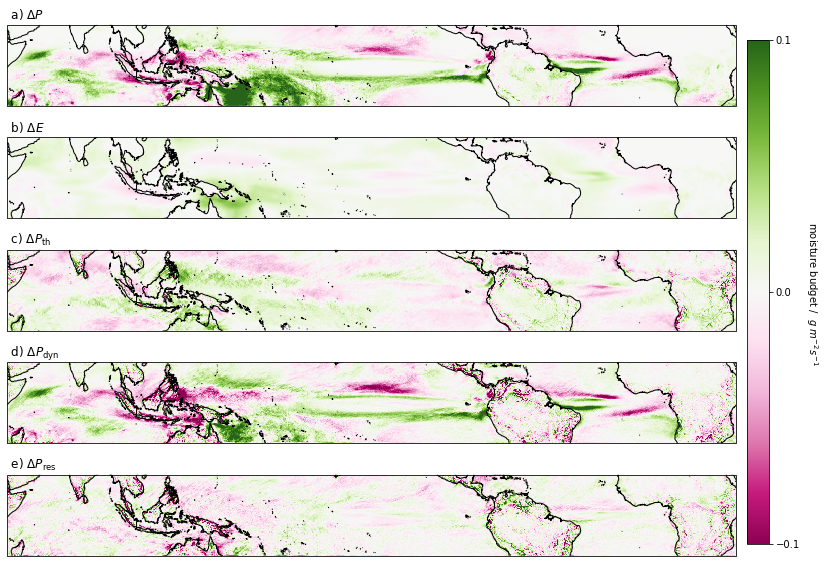

In [33]:
fig,xs = plt.subplots(5,1,figsize=(15,10), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=222)},facecolor="white")

clim=1e-1

ax=xs[0]
im =  delta_P_LR.plot(x="lon",y="lat",ax=ax,cmap='PiYG',add_colorbar=False,vmin=-clim,vmax=clim,transform=ccrs.PlateCarree())

metcalc.set_regional_cartopy(ax,extent=[0, 359, -20, 20])
ax.set_title(f" a) $ \Delta P $",loc="left")

ax=xs[1]
im =  delta_E_LR_pos.plot(x="lon",y="lat",ax=ax,cmap='PiYG',add_colorbar=False,vmin=-clim,vmax=clim,transform=ccrs.PlateCarree())

metcalc.set_regional_cartopy(ax,extent=[0, 359, -20, 20])
ax.set_title(f" b) $ \Delta E $",loc="left")

ax=xs[2]
im =  thermo_LR.plot(x="lon",y="lat",ax=ax,cmap='PiYG',vmin=-clim,vmax=clim,add_colorbar=False,transform=ccrs.PlateCarree())

metcalc.set_regional_cartopy(ax,extent=[0, 359, -20, 20])
#ax.set_title(fr" $ \int \delta \omega \  \frac{{dq}}{{dp}}$ ")
ax.set_title(f" c) $\Delta P_\mathrm{{th}}$  ",loc="left")


ax=xs[3]
im =  dynamic_LR.plot(x="lon",y="lat",ax=ax,cmap='PiYG',vmin=-clim,vmax=clim,add_colorbar=False,transform=ccrs.PlateCarree())

metcalc.set_regional_cartopy(ax,extent=[0, 359, -20, 20])
#ax.set_title(fr" $ \int \omega \ \delta \frac{{dq}}{{dp}}$ ")
ax.set_title(f" d) $ \Delta P_\mathrm{{dyn}} $ ",loc="left")

ax=xs[4]
im =  residual2_LR.plot(x="lon",y="lat",ax=ax,cmap='PiYG',vmin=-clim,vmax=clim,add_colorbar=False,transform=ccrs.PlateCarree())

metcalc.set_regional_cartopy(ax,extent=[0, 359, -20, 20])
#ax.set_title(fr" $ \int \omega \ \delta \frac{{dq}}{{dp}}$ ")
ax.set_title(" e) $\Delta P_\mathrm{res}$ ",loc="left")

metcalc.good_colorbar(im,fig,f" moisture budget / $ \ g \ m^{{-2}} s^{{-1}}$",label_kwargs={"labelpad": 20},cb_kwargs={"ticks" : [-0.1, 0, 0.1]})


plt.savefig('../plots/figure2.png', dpi=600,bbox_inches='tight')


## Advection and Convergence

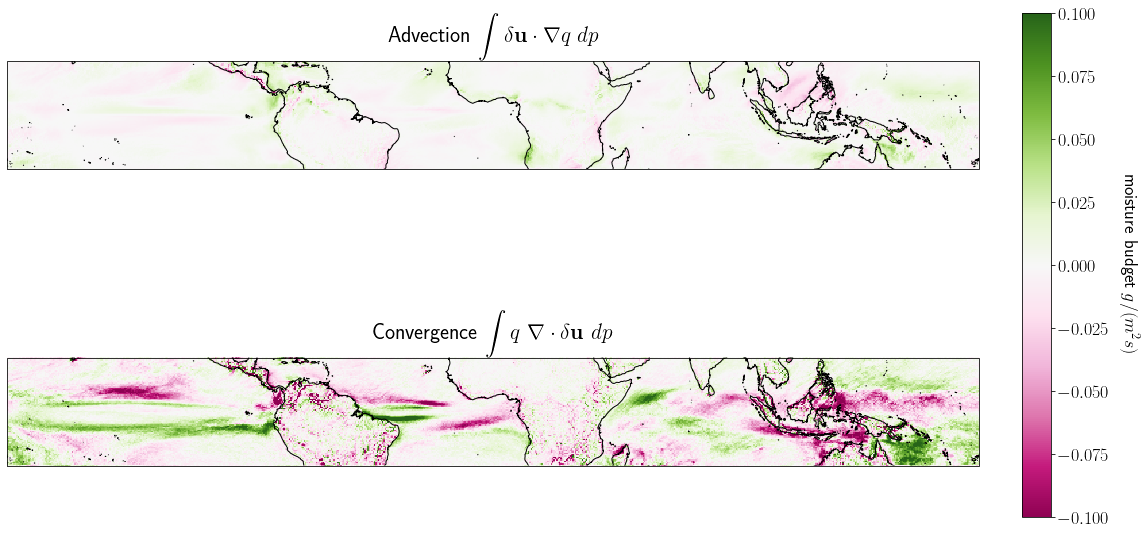

In [87]:
fig,xs = plt.subplots(2,1,figsize=(20,10), subplot_kw={'projection': ccrs.PlateCarree()})

clim=0.1

ax=xs[0]
im =  dynamic_advection_LR.plot(x="lon",y="lat",ax=ax,cmap='PiYG',add_colorbar=False,vmin=-clim,vmax=clim)

metcalc.set_regional_cartopy(ax,extent=[0, 359, -20, 20])
ax.set_title(fr"Advection  $ \int \Delta \mathbf{{u}} \cdot \nabla q \ dp $")


ax=xs[1]
im =  dynamic_convergence_LR.plot(x="lon",y="lat",ax=ax,cmap='PiYG',vmin=-clim,vmax=clim,add_colorbar=False)

metcalc.set_regional_cartopy(ax,extent=[0, 359, -20, 20])
#ax.set_title(fr" $\displaystyle \int \delta \omega \  \frac{{dq}}{{dp}}$ ")
ax.set_title(fr"Convergence $ \displaystyle \int  q \ \nabla \cdot \delta \mathbf{{u}} \ dp $")


good_colorbar(im,fig,fr" moisture budget $\displaystyle g / (m^2 s)$",pad=30)

# Calculate correlation between layer thickness and thermodynamic changes

In [12]:
def anomaly_from_tropical_mean(ds, lat=20) :
    return ds.sel(lat=slice(-lat,lat)) - metcalc.xr_fldmean(ds.sel(lat=slice(-lat,lat)))

In [9]:
dap0013_ta = read_mm_files(f"{WORK_DIR}/dap0013-dc/dap0013-dc_ta_20N-20S_19790?_timemean.nc",index=73)
dap0014_ta = read_mm_files(f"{WORK_DIR}/dap0014-dc/dap0014-dc_ta_20N-20S_19790?_timemean.nc",index=73)

dap0013_ta["hus"] = read_mm_files(f"{WORK_DIR}/dap0013-dc/dap0013-dc_hus_20N-20S_19790[2-9]_timemean.nc",index=74).hus
dap0014_ta["hus"] = read_mm_files(f"{WORK_DIR}/dap0014-dc/dap0014-dc_hus_20N-20S_19790[2-9]_timemean.nc",index=74).hus



In [10]:
dap0013_ta["Tv"] = metcalc.virtual_temperature(dap0013_ta.ta,dap0013_ta.hus)
dap0014_ta["Tv"] = metcalc.virtual_temperature(dap0014_ta.ta,dap0014_ta.hus)

dap0013_ta["500_200_thick"] = metcalc.xr_thickness(dap0013_ta.Tv,500,200)
dap0014_ta["500_200_thick"] = metcalc.xr_thickness(dap0014_ta.Tv,500,200)
dap0013_ta["400_200_thick"] = metcalc.xr_thickness(dap0013_ta.Tv,400,200)
dap0014_ta["400_200_thick"] = metcalc.xr_thickness(dap0014_ta.Tv,400,200)
dap0013_ta["400_150_thick"] = metcalc.xr_thickness(dap0013_ta.Tv,400,150)
dap0014_ta["400_150_thick"] = metcalc.xr_thickness(dap0014_ta.Tv,400,150)
dap0013_ta["700_200_thick"] = metcalc.xr_thickness(dap0013_ta.Tv,700,200)
dap0014_ta["700_200_thick"] = metcalc.xr_thickness(dap0014_ta.Tv,700,200)

In [13]:
dap_diff = dap0014_ta.mean("month") - dap0013_ta.mean("month")
dap_diff_an = anomaly_from_tropical_mean(dap_diff)

In [14]:
thermo = xr.open_dataset(f"{WORK_DIR}/thermo_pr_term.nc").pr

In [17]:
xr.corr(thermo.stack(coord=("lon", "lat")),dap_diff_an["400_150_thick"].stack(coord=("lon", "lat")),"coord").compute()

<xarray.DataArray ()>
array(0.03576545)

In [18]:
xr.corr(thermo.stack(coord=("lon", "lat")),dap_diff_an.sel(plev2=300).ta.stack(coord=("lon", "lat")),"coord").compute()

<xarray.DataArray ()>
array(-0.03074744)
Coordinates:
    plev     float64 3e+04
    plev2    float64 300.0